In [7]:
import torch
from torch import nn

In [32]:
from torchvision.utils import save_image
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "/kaggle/input/landscape-pictures/"
BATCH_SIZE = 8
LEARNING_RATE = 3e-4
NUM_WORKERS = 2
NUM_EPOCHS = 200
LOAD_MODEL = True
SAVE_MODEL = True
SIZE = 64
CHECKPOINT_UNET = ""

transforms = A.Compose(
    [
        A.Resize(width=SIZE, height=SIZE),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        A.HorizontalFlip(p=0.5),
        ToTensorV2(),
    
    ],
    
)


In [9]:
from PIL import Image
import os
from torch.utils.data import Dataset
import numpy as np

class LandScapeDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.list_file = os.listdir(self.root_dir)
        self.transforms = transforms

        
    def __len__(self):
        return len(self.list_file)
    

    def __getitem__(self, index):
        img_file = self.list_file[index]
        img_path = os.path.join(self.root_dir, img_file)
        input_img = np.array(Image.open(img_path).convert('RGB'))
        if self.transforms is not None:
            return self.transforms(image=input_img)['image']
        return input_img

torch.Size([2, 3, 64, 64])


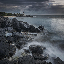

In [10]:
from torch.utils.data import DataLoader
te_dataset = LandScapeDataset(root_dir=TRAIN_DIR, transforms=transforms)
te_loader = DataLoader(te_dataset, batch_size=2, shuffle=True, num_workers=1)

batch= iter(te_loader)
images = next(batch)
import torchvision.transforms as T
images.shape
print(images.shape)
#print(torch.unique(images, return_counts=True))
transform = T.ToPILImage()
transform(images[0] * 0.5 + 0.5)

In [34]:
import torch
from torchvision.utils import save_image

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load("/kaggle/working/" + checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint)
    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:

In [27]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv(x)
    
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2, 2)
        self.emb_dim = emb_dim
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )
        
    def forward(self, x, t):
        s = self.conv(x)
        p = self.pool(s)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, p.shape[-2], p.shape[-1])
        return s, p + emb

    
class AttentionGate(nn.Module):
    def __init__(self, in_channels_input, in_channels_skip, out_channels):
        super().__init__()
        self.input_conv = nn.Sequential(
            nn.Conv2d(in_channels_input, out_channels, kernel_size=1, padding=0, stride=1),
            nn.BatchNorm2d(out_channels)
        )
        
        self.skip_conv = nn.Sequential(
            nn.Conv2d(in_channels_skip, out_channels, kernel_size=1, padding=0, stride=1),
            nn.BatchNorm2d(out_channels)
        )
        
        self.relu = nn.ReLU(inplace=True)
        
        self.output_conv = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=1, padding=0, stride=1),
            nn.Sigmoid()
        )
        
    def forward(self, inputs, skips):
        x = self.input_conv(inputs)
        s = self.skip_conv(skips)
        out = self.relu(x + s)
        out = self.output_conv(out)
        return out * skips
        
class DecoderBlock(nn.Module):
    def __init__(self, in_channels_input, in_channels_skip, out_channels, emb_dim=256):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.attention = AttentionGate(in_channels_input, in_channels_skip, out_channels)
        self.c1 = ConvBlock(in_channels_input + out_channels, out_channels)
        self.emb_dim = emb_dim
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )
        
        
    def forward(self, x, skip, t):
        
        x = self.up(x)
        skip = self.attention(x, skip)
        x = torch.cat([x, skip], dim=1)
        x = self.c1(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb
        
    
class AttentionUnet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512], time_dim=256, device='cuda'):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.device = device
        for feature in features:
            self.downs.append(EncoderBlock(in_channels, feature))
            in_channels = feature
                              

        self.b1 = ConvBlock(features[-1], features[-1] * 2)
        
        for feature in reversed(features):
            self.ups.append(DecoderBlock(feature * 2, feature, feature))
            
        self.final = nn.Conv2d(features[0], out_channels, kernel_size=1, padding=0)
        self.time_dim = time_dim
    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2).float() / channels)
        ).to(self.device)
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc
    
    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)
        
        skips = []
        for down in self.downs:
            s, x = down(x, t)
            skips.append(s)
        
        x = self.b1(x)
        
        for up in self.ups:
            a = skips.pop()
            x = up(x, a, t)
        
        return self.final(x)
        
x = torch.randn((5, 3, 64, 64))
model = AttentionUnet(3, 3, device='cpu')
t = x.new_tensor([500] * x.shape[0]).long()
print(model(x, t).shape)

torch.Size([5, 3, 64, 64])


In [16]:
import os
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
import logging

class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n):
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

In [38]:
import os
import torch
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader


def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    #im.save(path)
    
    img_grid = wandb.Image(
        im
    )
    wandb.log({"Real": img_grid})


def get_data(batch_size, image_size):
    transforms = A.Compose([
        A.Resize(80,80),  # args.image_size + 1/4 *args.image_size
        A.RandomResizedCrop(image_size, image_size, scale=(0.8, 1.0)),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ])
    dataset = LandScapeDataset(root_dir=TRAIN_DIR, transforms=transforms)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


def setup_logging(run_name):
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    os.makedirs(os.path.join("models", run_name), exist_ok=True)
    os.makedirs(os.path.join("results", run_name), exist_ok=True)

In [19]:
!pip install wandb
from kaggle_secrets import UserSecretsClient
import wandb
wandb.login(key=UserSecretsClient().get_secret("wandb_api"))
run = wandb.init(
    # Set the project where this run will be logged
    project="my-awesome-project",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": LEARNING_RATE,
        "EPOCHS": NUM_EPOCHS,
        "batch_size": BATCH_SIZE
    })



wandb: Currently logged in as: henry-laur. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [39]:
from torch.utils.tensorboard import SummaryWriter

def train(run_name, epochs, batch_size, size, device, lr):
    setup_logging(run_name)
    device = device
    dataloader = get_data(batch_size, size)
    model = AttentionUnet().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=size, device=device)
    logger = SummaryWriter(os.path.join("runs", run_name))
    l = len(dataloader)
    
    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_UNET, model, optimizer, LEARNING_RATE
        )
    for epoch in range(epochs):
        print(f"Starting epoch {epoch}:")
        pbar = tqdm(dataloader)
        for i, (images) in enumerate(pbar):
            images = images.to(device)
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)
            predicted_noise = model(x_t, t)
            loss = mse(noise, predicted_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix(MSE=loss.item())
            logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)


        sampled_images = diffusion.sample(model, n=images.shape[0])
        save_images(sampled_images, os.path.join("results", run_name, f"{epoch}.jpg"))
        torch.save(model.state_dict(), os.path.join("models", run_name, f"ckpt.pt"))
        wandb.save('/kaggle/working/models/' + run_name + '/*pt*')

def launch():
    train("DDPM_Uncondtional", NUM_EPOCHS, BATCH_SIZE, SIZE, DEVICE, LEARNING_RATE)

launch()

=> Loading checkpoint
Starting epoch 0:


100%|██████████| 540/540 [01:07<00:00,  7.98it/s, MSE=0.00741]
999it [00:13, 74.23it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 1:


100%|██████████| 540/540 [01:07<00:00,  8.05it/s, MSE=0.00941]
999it [00:13, 74.50it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 2:


100%|██████████| 540/540 [01:07<00:00,  8.06it/s, MSE=0.0244] 
999it [00:13, 74.00it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 3:


100%|██████████| 540/540 [01:06<00:00,  8.08it/s, MSE=0.0441] 
999it [00:13, 74.75it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 4:


100%|██████████| 540/540 [01:07<00:00,  8.02it/s, MSE=0.0482] 
999it [00:13, 73.00it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 5:


100%|██████████| 540/540 [01:08<00:00,  7.94it/s, MSE=0.00475]
999it [00:13, 74.61it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 6:


100%|██████████| 540/540 [01:07<00:00,  7.98it/s, MSE=0.0156] 
999it [00:13, 74.84it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 7:


100%|██████████| 540/540 [01:07<00:00,  8.01it/s, MSE=0.0552] 
999it [00:13, 74.01it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 8:


100%|██████████| 540/540 [01:06<00:00,  8.07it/s, MSE=0.0205] 
999it [00:13, 74.66it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 9:


100%|██████████| 540/540 [01:07<00:00,  8.02it/s, MSE=0.0212] 
999it [00:13, 74.11it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 10:


100%|██████████| 540/540 [01:07<00:00,  8.02it/s, MSE=0.0327] 
999it [00:13, 74.68it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 11:


100%|██████████| 540/540 [01:07<00:00,  8.00it/s, MSE=0.0552] 
999it [00:13, 74.05it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 12:


100%|██████████| 540/540 [01:07<00:00,  8.06it/s, MSE=0.0249] 
999it [00:13, 74.57it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 13:


100%|██████████| 540/540 [01:07<00:00,  7.99it/s, MSE=0.0408] 
999it [00:13, 74.65it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 14:


100%|██████████| 540/540 [01:07<00:00,  8.02it/s, MSE=0.0222] 
999it [00:13, 73.59it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 15:


100%|██████████| 540/540 [01:07<00:00,  7.99it/s, MSE=0.0473] 
999it [00:13, 74.58it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 16:


100%|██████████| 540/540 [01:07<00:00,  7.97it/s, MSE=0.00226]
999it [00:13, 73.89it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 17:


100%|██████████| 540/540 [01:07<00:00,  8.04it/s, MSE=0.0343] 
999it [00:13, 74.45it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 18:


100%|██████████| 540/540 [01:08<00:00,  7.92it/s, MSE=0.0259] 
999it [00:13, 74.46it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 19:


100%|██████████| 540/540 [01:07<00:00,  8.01it/s, MSE=0.0195] 
999it [00:13, 73.96it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 20:


100%|██████████| 540/540 [01:07<00:00,  8.02it/s, MSE=0.0117] 
999it [00:13, 74.47it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 21:


100%|██████████| 540/540 [01:07<00:00,  7.98it/s, MSE=0.0703] 
999it [00:13, 73.73it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 22:


100%|██████████| 540/540 [01:07<00:00,  8.02it/s, MSE=0.00697]
999it [00:13, 74.59it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 23:


100%|██████████| 540/540 [01:07<00:00,  7.99it/s, MSE=0.0225] 
999it [00:13, 73.90it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 24:


100%|██████████| 540/540 [01:07<00:00,  7.98it/s, MSE=0.00975]
999it [00:13, 74.56it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 25:


100%|██████████| 540/540 [01:07<00:00,  7.97it/s, MSE=0.00832]
999it [00:13, 74.53it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 26:


100%|██████████| 540/540 [01:07<00:00,  7.98it/s, MSE=0.0253] 
999it [00:13, 73.64it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 27:


100%|██████████| 540/540 [01:06<00:00,  8.08it/s, MSE=0.0137] 
999it [00:13, 74.50it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 28:


100%|██████████| 540/540 [01:06<00:00,  8.06it/s, MSE=0.0108] 
999it [00:13, 74.05it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 29:


100%|██████████| 540/540 [01:07<00:00,  8.03it/s, MSE=0.0266] 
999it [00:13, 74.50it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 30:


100%|██████████| 540/540 [01:07<00:00,  8.01it/s, MSE=0.0395] 
999it [00:13, 74.03it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 31:


100%|██████████| 540/540 [01:07<00:00,  8.04it/s, MSE=0.0101] 
999it [00:13, 74.56it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 32:


100%|██████████| 540/540 [01:07<00:00,  7.98it/s, MSE=0.0612] 
999it [00:13, 74.48it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 33:


100%|██████████| 540/540 [01:07<00:00,  8.00it/s, MSE=0.02]   
999it [00:13, 74.08it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 34:


100%|██████████| 540/540 [01:07<00:00,  7.99it/s, MSE=0.0195] 
999it [00:13, 74.53it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 35:


100%|██████████| 540/540 [01:07<00:00,  7.99it/s, MSE=0.0673] 
999it [00:13, 73.91it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 36:


100%|██████████| 540/540 [01:07<00:00,  7.98it/s, MSE=0.0453] 
999it [00:13, 74.15it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 37:


100%|██████████| 540/540 [01:07<00:00,  7.99it/s, MSE=0.0142] 
999it [00:13, 73.89it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 38:


100%|██████████| 540/540 [01:07<00:00,  8.04it/s, MSE=0.0608] 
999it [00:13, 74.57it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 39:


100%|██████████| 540/540 [01:07<00:00,  7.98it/s, MSE=0.00979]
999it [00:13, 74.66it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 40:


100%|██████████| 540/540 [01:06<00:00,  8.06it/s, MSE=0.0184] 
999it [00:13, 74.08it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 41:


100%|██████████| 540/540 [01:07<00:00,  8.03it/s, MSE=0.0124] 
999it [00:13, 74.61it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 42:


100%|██████████| 540/540 [01:07<00:00,  8.00it/s, MSE=0.00615]
999it [00:13, 73.99it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 43:


100%|██████████| 540/540 [01:07<00:00,  8.03it/s, MSE=0.01]   
999it [00:13, 74.53it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 44:


100%|██████████| 540/540 [01:07<00:00,  8.02it/s, MSE=0.00744]
999it [00:13, 73.78it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 45:


100%|██████████| 540/540 [01:06<00:00,  8.06it/s, MSE=0.00941]
999it [00:13, 74.33it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 46:


100%|██████████| 540/540 [01:08<00:00,  7.89it/s, MSE=0.026]  
999it [00:13, 74.47it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 47:


100%|██████████| 540/540 [01:07<00:00,  7.95it/s, MSE=0.0287] 
999it [00:13, 73.91it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 48:


100%|██████████| 540/540 [01:07<00:00,  7.97it/s, MSE=0.103]  
999it [00:13, 74.55it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 49:


100%|██████████| 540/540 [01:07<00:00,  8.01it/s, MSE=0.0177] 
999it [00:13, 73.90it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 50:


100%|██████████| 540/540 [01:07<00:00,  7.98it/s, MSE=0.00752]
999it [00:13, 74.38it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 51:


100%|██████████| 540/540 [01:07<00:00,  7.99it/s, MSE=0.101]  
999it [00:13, 74.00it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 52:


100%|██████████| 540/540 [01:07<00:00,  7.99it/s, MSE=0.00876]
999it [00:13, 74.19it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 53:


100%|██████████| 540/540 [01:07<00:00,  8.03it/s, MSE=0.0316] 
999it [00:13, 74.60it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 54:


100%|██████████| 540/540 [01:06<00:00,  8.06it/s, MSE=0.0154] 
999it [00:13, 74.22it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 55:


100%|██████████| 540/540 [01:06<00:00,  8.06it/s, MSE=0.0397] 
999it [00:13, 74.42it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 56:


100%|██████████| 540/540 [01:07<00:00,  8.04it/s, MSE=0.0145] 
999it [00:13, 73.95it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 57:


100%|██████████| 540/540 [01:07<00:00,  8.03it/s, MSE=0.0121] 
999it [00:13, 74.55it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 58:


100%|██████████| 540/540 [01:07<00:00,  8.01it/s, MSE=0.0174] 
999it [00:13, 74.14it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 59:


100%|██████████| 540/540 [01:07<00:00,  8.01it/s, MSE=0.00426]
999it [00:13, 74.34it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 60:


100%|██████████| 540/540 [01:07<00:00,  7.98it/s, MSE=0.00669]
999it [00:13, 74.31it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 61:


100%|██████████| 540/540 [01:07<00:00,  7.99it/s, MSE=0.074]  
999it [00:13, 73.86it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 62:


100%|██████████| 540/540 [01:07<00:00,  7.96it/s, MSE=0.0196] 
999it [00:13, 74.60it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 63:


100%|██████████| 540/540 [01:07<00:00,  7.98it/s, MSE=0.045]  
999it [00:13, 74.02it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 64:


100%|██████████| 540/540 [01:08<00:00,  7.90it/s, MSE=0.0383] 
999it [00:13, 74.53it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 65:


100%|██████████| 540/540 [01:07<00:00,  7.95it/s, MSE=0.0182] 
999it [00:13, 74.46it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 66:


100%|██████████| 540/540 [01:07<00:00,  8.02it/s, MSE=0.0111] 
999it [00:13, 73.81it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 67:


100%|██████████| 540/540 [01:07<00:00,  7.98it/s, MSE=0.0182] 
999it [00:13, 74.52it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 68:


100%|██████████| 540/540 [01:07<00:00,  8.03it/s, MSE=0.0111] 
999it [00:13, 74.33it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 69:


100%|██████████| 540/540 [01:07<00:00,  8.03it/s, MSE=0.0541] 
999it [00:13, 74.62it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 70:


100%|██████████| 540/540 [01:07<00:00,  8.01it/s, MSE=0.0573] 
999it [00:13, 74.10it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 71:


100%|██████████| 540/540 [01:07<00:00,  8.01it/s, MSE=0.0341] 
999it [00:13, 74.69it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 72:


100%|██████████| 540/540 [01:07<00:00,  7.95it/s, MSE=0.0267] 
999it [00:13, 74.38it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 73:


100%|██████████| 540/540 [01:07<00:00,  7.99it/s, MSE=0.00958]
999it [00:13, 73.90it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 74:


100%|██████████| 540/540 [01:07<00:00,  7.96it/s, MSE=0.00802]
999it [00:13, 74.60it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 75:


100%|██████████| 540/540 [01:07<00:00,  7.95it/s, MSE=0.0294] 
999it [00:13, 73.93it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 76:


100%|██████████| 540/540 [01:07<00:00,  7.97it/s, MSE=0.0195] 
999it [00:13, 74.58it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 77:


100%|██████████| 540/540 [01:07<00:00,  7.95it/s, MSE=0.0353] 
999it [00:13, 74.65it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 78:


100%|██████████| 540/540 [01:07<00:00,  8.06it/s, MSE=0.0496] 
999it [00:13, 74.14it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 79:


100%|██████████| 540/540 [01:07<00:00,  8.00it/s, MSE=0.0253] 
999it [00:13, 74.74it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 80:


100%|██████████| 540/540 [01:07<00:00,  8.00it/s, MSE=0.048]  
999it [00:13, 74.14it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 81:


100%|██████████| 540/540 [01:06<00:00,  8.07it/s, MSE=0.0298] 
999it [00:13, 74.50it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 82:


100%|██████████| 540/540 [01:07<00:00,  8.05it/s, MSE=0.00972]
999it [00:13, 73.99it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 83:


100%|██████████| 540/540 [01:07<00:00,  8.02it/s, MSE=0.019]  
999it [00:13, 74.63it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 84:


100%|██████████| 540/540 [01:07<00:00,  8.00it/s, MSE=0.0596] 
999it [00:13, 74.44it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 85:


100%|██████████| 540/540 [01:07<00:00,  8.00it/s, MSE=0.0324] 
999it [00:13, 74.01it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 86:


100%|██████████| 540/540 [01:07<00:00,  7.95it/s, MSE=0.00503]
999it [00:13, 74.61it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 87:


100%|██████████| 540/540 [01:07<00:00,  8.00it/s, MSE=0.0608] 
999it [00:13, 74.00it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 88:


100%|██████████| 540/540 [01:07<00:00,  7.97it/s, MSE=0.02]   
999it [00:13, 74.44it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 89:


100%|██████████| 540/540 [01:07<00:00,  7.98it/s, MSE=0.0213] 
999it [00:13, 73.79it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 90:


100%|██████████| 540/540 [01:07<00:00,  7.95it/s, MSE=0.0351] 
999it [00:13, 74.62it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 91:


100%|██████████| 540/540 [01:08<00:00,  7.94it/s, MSE=0.02]   
999it [00:13, 74.48it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 92:


100%|██████████| 540/540 [01:07<00:00,  8.03it/s, MSE=0.00416]
999it [00:13, 74.06it/s]
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


Starting epoch 93:


 79%|███████▊  | 425/540 [00:52<00:14,  8.06it/s, MSE=0.0116] 
